# Relative Entropy with `limlam_mocker`

- This notebook is intended to present how to produce a point-wise differential relative entropy analysis over intensity maps generated through `limlam_mocker`

- I suggest getting acquainted with the `limlam_mocker` general use readme first

Author: Patrick Horlaville

NOTE: 

- for supplemental information or any question you might have going through this readme, refer to https://arxiv.org/abs/2309.15733 (specifically, at $\S$ 2.2 & 4.3 for relative entropy discussion)
- or contact me at : phorlaville24@ubishops.ca

First, read this notebook from the root limCode folder, so the imports work correctly. Therefore, this whole notebook will run as though its location is:

In [2]:
%cd '/fs/lustre/scratch/horlaville/clara_limlam/limCode2020-master_clara_2/'

/fs/lustre/scratch/horlaville/clara_limlam/limCode2020-master_clara_2


Then, import all packages:

In [3]:
# base imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# various math package imports
import math
from scipy import special
from scipy import interpolate
import astropy.units as u 
from scipy.ndimage import gaussian_filter

# base intensity mapping package
from lim import lim 

# My plotting preferences
matplotlib.rcParams.update({'font.size': 18,'figure.figsize':[8,7]}) 
#plt.rcParams["mathtext.fontset"] = "dejavuserif"

# Dongwoo's plotting preferences, which I used for my paper:
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = '\\usepackage{tgheros}\\usepackage{sansmath}\\sansmath'

# used to check on the running time of particular computations
from datetime import datetime

Then, we can load the lim model, here for [C II]:

In [12]:
# Initialize LineModel with default model
m = lim()
m_cii = lim('Lichen_v4', doSim = True)

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


We set our simulation parameters:

In [13]:
m_cii.update(model_par = {'zdex': 0.4,
 'M0': 1900000000.0,
 'Mmin': 20000000000,
 'alpha_MH1': 0.74,
 'alpha_LCII': 0.024,
 'alpha0': -1.412,
 'gamma0': 0.31,
 'BehrooziFile': 'sfr_reinterp.dat'},
            dnu = 2.8*u.GHz,
            nuObs = 270*u.GHz,
            Delta_nu = 40*u.GHz,
            tobs = 40000*u.h,
            Omega_field = 4*u.deg**2,
            catalogue_file = '/home/dongwooc/scratchspace/pprun_hiz_npz/COMAP_z5.8-7.9_960Mpc_seed_13819.npz')

In [14]:
m_cii.sigma_N

<Quantity 3172.81108492 Jy / sr>

And load the cube of intensities:

In [5]:
cii_cube_zdex04 = m_cii.maps

Loading .npz catalogues...


For the relative entropy analysis, we are interested in the distribution of the voxels' [C II] signal distribution from our cube:

In [6]:
binning = np.logspace(0, np.log10(50000), 100)
center = (binning[:-1] + binning[1:]) / 2

Text(0.5, 1.0, '[C II] Voxel Base Signal Distribution')

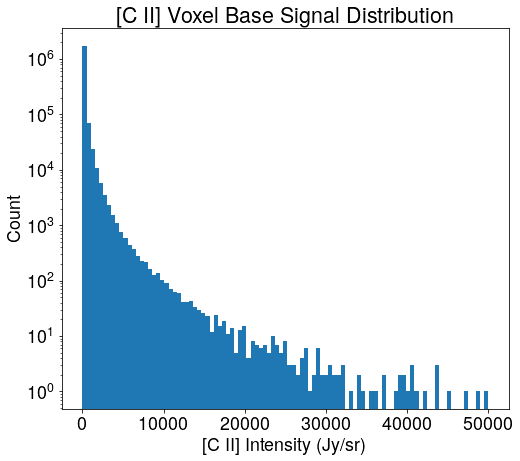

In [19]:
n_cii_zdex04, _, _ = plt.hist(cii_cube_zdex04.value.flatten(), bins = binning)

plt.xlabel('[C II] Intensity (Jy/sr)')
plt.ylabel('N')
plt.yscale('log')
plt.title('[C II] Voxel Base Signal Distribution')

In [21]:
m_cii.update(model_par = {'zdex': 0.3,
 'M0': 1900000000.0,
 'Mmin': 20000000000,
 'alpha_MH1': 0.74,
 'alpha_LCII': 0.024,
 'alpha0': -1.412,
 'gamma0': 0.31,
 'BehrooziFile': 'sfr_reinterp.dat'})

In [22]:
cii_cube_zdex03 = m_cii.maps

Loading .npz catalogues...


In [23]:
m_cii.update(model_par = {'zdex': 0.5,
 'M0': 1900000000.0,
 'Mmin': 20000000000,
 'alpha_MH1': 0.74,
 'alpha_LCII': 0.024,
 'alpha0': -1.412,
 'gamma0': 0.31,
 'BehrooziFile': 'sfr_reinterp.dat'})

In [24]:
cii_cube_zdex05 = m_cii.maps

Loading .npz catalogues...


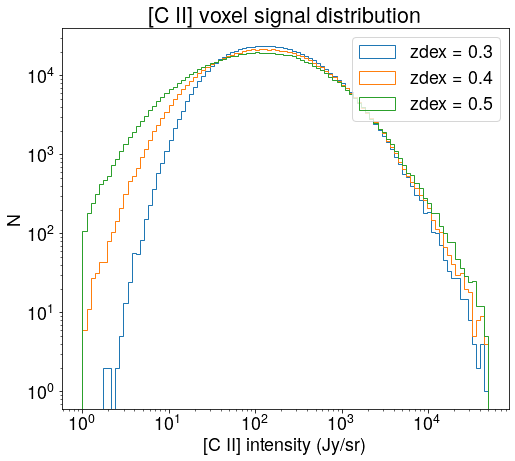

In [36]:
n_cii_zdex03, _, _ = plt.hist(cii_cube_zdex03.value.flatten(), bins = binning, label = 'zdex = 0.3', histtype = 'step')
n_cii_zdex04, _, _ = plt.hist(cii_cube_zdex04.value.flatten(), bins = binning, label = 'zdex = 0.4', histtype = 'step')
n_cii_zdex05, _, _ = plt.hist(cii_cube_zdex05.value.flatten(), bins = binning, label = 'zdex = 0.5', histtype = 'step')


plt.xlabel('[C II] intensity (Jy/sr)')
plt.ylabel('N')
plt.yscale('log')
plt.xscale('log')
plt.title('[C II] voxel signal distribution')
plt.legend()

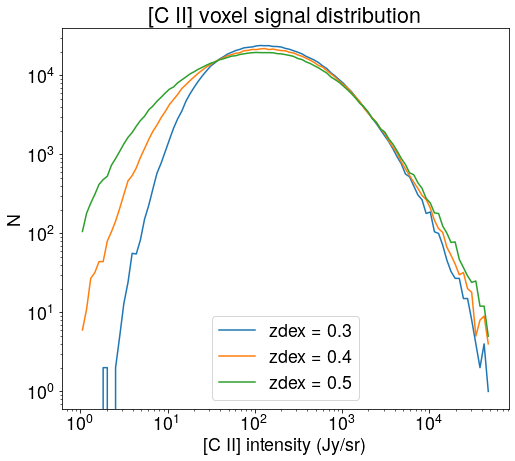

In [41]:
plt.plot(center, n_cii_zdex03, label = 'zdex = 0.3')
plt.plot(center, n_cii_zdex04, label = 'zdex = 0.4')
plt.plot(center, n_cii_zdex05, label = 'zdex = 0.5')

plt.xlabel('[C II] intensity (Jy/sr)')
plt.ylabel('N')
plt.yscale('log')
plt.xscale('log')
plt.title('[C II] voxel signal distribution')
plt.legend()

/tmp/ipykernel_3286770/1652695955.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(center, np.log(n_cii_zdex03/n_cii_zdex04), label = '0.3/0.4')


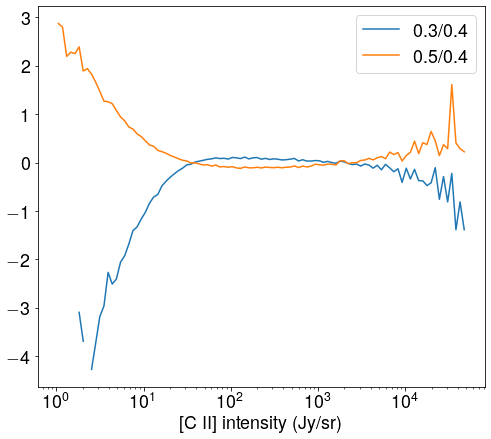

In [44]:
plt.plot(center, np.log(n_cii_zdex03/n_cii_zdex04), label = '0.3/0.4')
plt.plot(center, np.log(n_cii_zdex05/n_cii_zdex04), label = '0.5/0.4')

plt.xlabel('[C II] intensity (Jy/sr)')
#plt.ylabel('N')
#plt.yscale('log')
plt.xscale('log')
#plt.title('[C II] voxel signal distribution')
plt.legend()

/tmp/ipykernel_3286770/2018124029.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(center, n_cii_zdex04*(np.log(n_cii_zdex05/n_cii_zdex04) - np.log(n_cii_zdex03/n_cii_zdex04)))


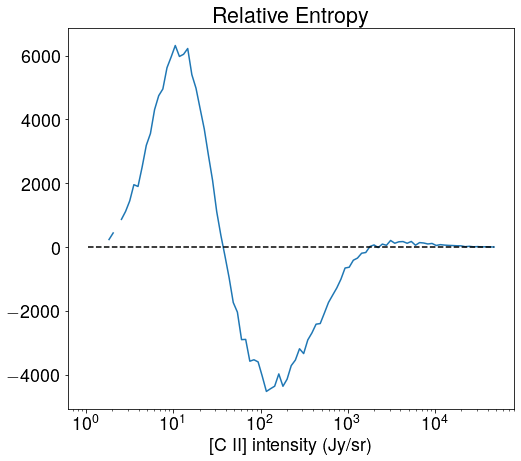

In [49]:
plt.plot(center, n_cii_zdex04*(np.log(n_cii_zdex05/n_cii_zdex04) - np.log(n_cii_zdex03/n_cii_zdex04)))

plt.xlabel('[C II] intensity (Jy/sr)')
#Àplt.ylabel('N')
#plt.yscale('log')
plt.xscale('log')
plt.title('Relative Entropy')

plt.hlines(y = 0, xmin = center[0], xmax = center[-1], linestyle = '--', color = 'k')

Perform on all lightcones, across all the parameters

In [9]:
binning = np.logspace(1, 5, 50)
center = (binning[:-1] + binning[1:]) / 2

In [4]:
avg_zdex03_sig = np.load('/mnt/scratch-lustre/horlaville/nuObs270/dsrel/sig/n_avg_zdex0-3.npy')
avg_zdex04_sig = np.load('/mnt/scratch-lustre/horlaville/nuObs270/dsrel/sig/n_avg_basis.npy')
avg_zdex05_sig = np.load('/mnt/scratch-lustre/horlaville/nuObs270/dsrel/sig/n_avg_zdex0-5.npy')

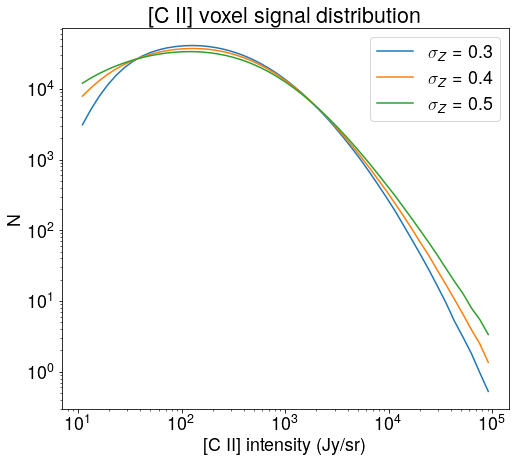

In [11]:
plt.plot(center, avg_zdex03_sig, label = r'$\sigma_Z$ = 0.3')
plt.plot(center, avg_zdex04_sig, label = r'$\sigma_Z$ = 0.4')
plt.plot(center, avg_zdex05_sig, label = r'$\sigma_Z$ = 0.5')

plt.xlabel('[C II] intensity (Jy/sr)')
plt.ylabel('N')
plt.yscale('log')
plt.xscale('log')
plt.title('[C II] voxel signal distribution')
plt.legend()

plt.savefig('paper_figs/hist.png', bbox_inches = 'tight')

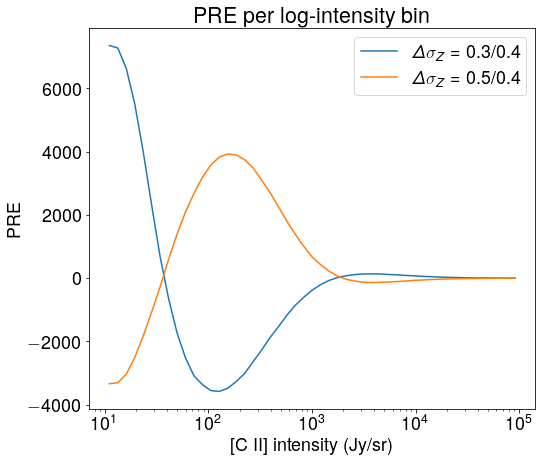

In [22]:
plt.plot(center, -avg_zdex04_sig*np.log(avg_zdex03_sig/avg_zdex04_sig), label = r'$\Delta \sigma_Z$ = 0.3/0.4')
plt.plot(center, -avg_zdex04_sig*np.log(avg_zdex05_sig/avg_zdex04_sig), label = r'$\Delta \sigma_Z$ = 0.5/0.4')

plt.xlabel('[C II] intensity (Jy/sr)')
plt.ylabel('PRE')
#plt.yscale('log')
plt.xscale('log')
plt.title('PRE per log-intensity bin')
plt.legend()

plt.savefig('paper_figs/pre.png', bbox_inches = 'tight')

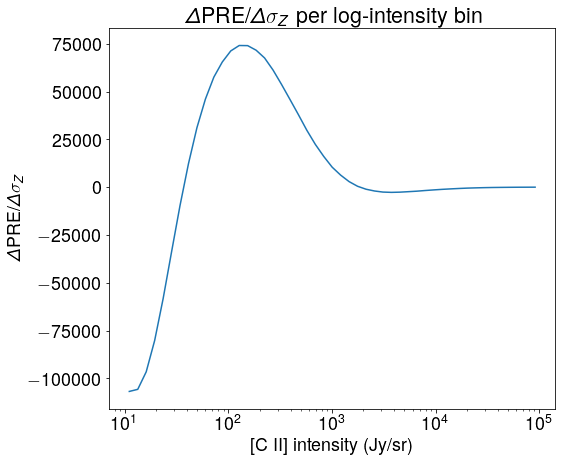

In [23]:
plt.plot(center, -avg_zdex04_sig*(np.log(avg_zdex05_sig/avg_zdex04_sig) - np.log(avg_zdex03_sig/avg_zdex04_sig))/0.1)

plt.xlabel('[C II] intensity (Jy/sr)')
plt.ylabel(r'$\Delta$PRE/$\Delta \sigma_Z$')
#plt.yscale('log')
plt.xscale('log')
plt.title(r'$\Delta$PRE/$\Delta \sigma_Z$ per log-intensity bin')

plt.savefig('paper_figs/dpre.png', bbox_inches = 'tight')